# Exercise 4 - Spelling Correction with Naive Bayes (30 Points)

In this exercise you will learn about a fun application of the *Naive Bayes* classifier: Spelling correction. For the
informal and vivid character of natural language, the correction of syntactic and semantic errors in written lan-
guage is an extremely hard task. Here you will challenge this problem by applying one of the simplest classification
algorithms, namely Naive Bayes and see how it performs.

In the event of a persistent problem, do not hesitate to contact the course instructors under
- paul.kahlmeyer@uni-jena.de

### Submission

- Deadline of submission:
        x.y.z
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=18310)

## Problem statement
We frame spelling correction as a classification problem and use Bayesian inference to obtain results. Although the
basic problem statement is straightforward, there is plenty of room to improve the here applied models, initially
published by Peter Norvig.

Given an observation $x$ and a corpus of words $W$. For spelling correction, we want to find the most likely correction $w\in W$ for $x$.
In other words, we are looking for 

\begin{align}
\text{argmax}_{w\in W}p(w|x)&=\text{argmax}_{w\in W}\cfrac{p(x|w)p(w)}{p(x)}\\
&=\text{argmax}_{w\in W}p(x|w)p(w)
\end{align}

In practice, we do not want to maximize over the complete corpus of words, but rather only over a set of candidate words $C_x\subset W$ that depends on the observed pattern $x$.

\begin{align}
\text{argmax}_{w\in C}p(x|w)p(w)
\end{align}

## Language Model
The probability $p(w)$ is also called **language model**, since it represents our model of how words are distributed.
There are multiple classes of language models. 
The simplest class of model is the unigram model, where the probability of each word is fixed and can be obtained by using the frequency of its occurrence in a given corpus.
Within the directory `books` you will find several `.txt` files that contain (parts) of books from the [Project Gutenberg](www.gutenberg.org). This source shall provide the basis for obtaining the corpus $W$ and for training a language model.

Note: Due to some legal issues, Project Gutenberg blocks IP adresses coming from germany.

### Task 1 (2 Points)
Load the book texts from the `.txt` files, filter the alphabetic
expressions (hint: use regex) and calculate the frequencies of occurrences of the existing words.
What are the top 10 most occuring words? 

Make sure to store $W$ in a data structure, where you can quickly check if $w\in W$ for a word $w$ (see [here](https://wiki.python.org/moin/TimeComplexity)).

Hints:
- the files are encoded in utf-8
- use [regex](https://docs.python.org/3/library/re.html) to filter for words

In [1]:
import numpy as np
import re
import collections
import os
import string
import matplotlib.pyplot as plt
import pickle

In [2]:
# TODO: load books
p = 'books'
words = []
for f in os.listdir(p):
    content =  open(os.path.join(p,f), encoding='utf8').read()
    words += re.findall(r'\w+', content.lower())

# TODO: count words
n_words = len(words)
words = collections.Counter(words)
words.most_common(10)

[('the', 16360),
 ('and', 10612),
 ('to', 9916),
 ('of', 8799),
 ('a', 7347),
 ('i', 7246),
 ('in', 5450),
 ('he', 4745),
 ('was', 4738),
 ('that', 4695)]

In [3]:
len(words)

15116

### Task 2 (1 Point)
Use the loaded corpus to implement a function that resembles our language model.
Use relative frequencies as estimates for $p(w)$.

In [4]:
def language_model(w):
    # TODO: implement language model
    if w in words:
        return words[w] / n_words
    else:
        return 0

language_model('the')

0.04713257621591099

## Candidate Words
Real-world-spelling-errors take multiple shapes. There are typographical errors like insertions, deletions and trans-
positions of letters, and there are cognitive errors where the writer substitutes a wrong spelling of a homophone or
near-homophone (e.g., dessert for desert, or piece for peace). The detection of the latter require context information
and therefore are hard to detect. Thus we focus on the former, which are errors that were produced by the following
operations:
- transposition (e.g. "caress" for "actress" : "ac" $\rightarrow$ "ca")
- deletion ("acress" for "actress": missing "t")
- substitutions ("acress" for "access": substituted "r" for "c")
- insertions ("actresss" for "actress": added "s")

Given an observation $x$, we create a set of possible candidates $C_x$ by applying all the possible edit operators on $x$. By concatenating operations, you can transform each word into any other arbitrary word. Yet, to keep things simply
we only consider candidates with *at most one* edit distance away from $x$. 

For instance, the correction candidates for the word "nie", could be:

\begin{equation}
C_{\text{nie}} = \{\text{die}, \text{lie}, \text{pie}, \text{tie}, \text{nice}, \text{nine}, \text{in}\}
\end{equation}

### Task 3 (5 Points)
Implement a function that creates a set of all possible correction candidates for a given observation $x$,
that are at most one edit distance away from $x$. You do not need to concatenate operations! To make things even simpler:
- you can ignore candidates, that do not occur in our corpus
- if none of the candidates is known, return the word itself

What is the set of correction candidates for the word "frod"?

In [5]:
def transposes(x):
    # TODO: possible transpositions
    return [x[:i] + x[i+1]+ x[i]+ x[i+2:] for i in range(len(x)-1)] 

def deletes(x):
    # TODO: possible deletes
    return [x[:i] + x[i+1:] for i in range(len(x))]

def substitutions(x):
    # TODO: possible substitutions
    alpha = string.ascii_lowercase
    return [x[:i] + c + x[i+1:] for i in range(len(x)) for c in alpha]
    
def insertions(x):
    # TODO: possible insertions
    alpha = string.ascii_lowercase
    return [x[:i] + c + x[i:] for i in range(len(x)+1) for c in alpha]

def candidates(x): 
    # TODO: possible candidates
    cands = transposes(x) + deletes(x) + substitutions(x) + insertions(x)
    cands.append(x)
    cands = list(set(cands))
    return [w for w in cands if w in words]


candidates("frod")

['rod', 'ford', 'from', 'fro', 'food']

## Error Model
Recall the problem statement:
The probability $p(x|w)$ for $w\in C\subset W$ is also called **error model**, since it represents our model of correct words (candidates) are altered into the observed pattern $x$.

A very simple error model is can be achieved by setting

\begin{equation}
p(x|w) := p(w)
\end{equation}

which reduces our initial problem to 

\begin{align}
\text{argmax}_{w\in C}p(w)p(w) = \text{argmax}_{w\in C}p(w)
\end{align}

### Task 4 (2 Points)
Implement a function `correction`, that returns $\text{argmax}_{w\in W}p(w|x)$ for a given input $x$, based on the above definition.

Also think about what `correction` should return
- if $x$ is a known word?
- if $x$ is unknown and has no correction candidates?

What is the correction for the word "frod"?

In [7]:
def correction(x): 
    # TODO: return correction candidate
    if x in words:
        return x
    else:
        can = candidates(x)
        if len(can)>0:
            probs = [language_model(c) for c in can]
            return can[np.argmax(probs)]
        else:
            return x

correction('sucess')

'success'

### Task 5 (2 Points)
The file `dataset.p` contains a list of spelling data from several [corpora of misspellings](https://www.dcs.bbk.ac.uk/~ROGER/corpora.html), where each item contains a tuple of the form:

\begin{equation}
\text{misspelled word, correct word}
\end{equation}

The dataset has been preprocessed, so each misspelling is one edit distance away from the correct word.
Load the dataset and split it into a train- and testset.

In [8]:
# TODO: Load dataset (1 Point)
dataset = pickle.load(open('dataset.p', 'rb') )
dataset = np.array(dataset)

dataset = np.load('dataset.p', allow_pickle=True)
dataset = np.array(dataset)


# TODO: Split into train- and testset (1 Point)
np.random.seed(0)
np.random.shuffle(dataset)
train_perc = 0.8
train_amount = int(train_perc*len(dataset))
trainset = dataset[:train_amount]
testset = dataset[train_amount:]

### Task 6 (3 Points)


Implement a function `validate`, that takes a correction function (takes a word, outputs a suggestion) tries to correct the typos in the testset. Use only the data, where the correct word is actually in our word corpus $W$.

`validate` should return a list of the cases, where the correction failed, as well as the success rate (percentage of correctly corrected typos).

What is your success rate? On which words did your spelling correction fail and why?

In [9]:
def validate(correction_function):
    # TODO: estimate success rate
        
    failed = []
    count = 0
    for wrong, right in testset:
        if right in words:
            count += 1
            c = correction_function(wrong)
            if c != right: 
                failed.append((right, c, wrong))
    success_rate = 1 - (len(failed) / count)
    return failed, success_rate

# TODO: estimate success rate, view failed corrections
failed, sr = validate(correction)
print(f'Success rate: {sr}')
for right, c , wrong in failed[:10]:
    print(f'Observed: {wrong}\tCorrected: {c}\tActual: {right}')
    
print(len(failed))

Success rate: 0.7166666666666667
Observed: put	Corrected: put	Actual: but
Observed: remove	Corrected: remove	Actual: removed
Observed: hide	Corrected: hide	Actual: hid
Observed: couse	Corrected: house	Actual: cause
Observed: move	Corrected: move	Actual: moved
Observed: thing	Corrected: thing	Actual: think
Observed: looses	Corrected: loose	Actual: loses
Observed: tham	Corrected: that	Actual: them
Observed: folloy	Corrected: follow	Actual: folly
Observed: forme	Corrected: former	Actual: form
561


## The Noisy Channel Model

By analyzing the output of your spelling corrector, you find examples where the corrected word is indeed a real
word, but not the expected one, for example:

\begin{equation}
w=\text{"fat"}, x=\text{"fet"}, \text{correction}=\text{"get"}
\end{equation}

This phenomena occurs due to the simplistic nature of our language model. 
Unigram models do not include context sensitive information. Thus, improving the language model should naturally
improve the validation results.


Chapter 5.1 of the book *Speech and Language Processing* by Daniel Jurafsky & James H. Martin introduces another model to improve the success rate. 
Instead of treating each error equally, we now consider the probability of error occurrences.
You find this chapter in the file `chapter5.pdf`.

Read the chapter. In order to apply the noisy channel model, we need four confusion matrices:
- deletion
- insertion
- substitution
- transposition

In order to construct these matrices, we need a way to find out, which transformation took place.

### Task 7 (5 Points)

Implement the function `get_transformation`, which takes the correct word and the misspelled word as input. The function should output three things:
- ID of transformation (deletion, insertion, substitution or transposition)
- x of transformation
- y of transformation

Read in the chapter, how x and y are defined for each transformation. Use the fact, that every misspelling only has one of the transformations applied on it.

In [1]:
def get_transformation(wrong, right):
    # TODO: returns id, x, y of transformation
    i = 0
    while i< len(wrong) and i < len(right) and wrong[i] == right[i]:
        i += 1
        
    if len(wrong) < len(right):
        # deletion
        if i == 0:
            # deletion of first letter
            return 'del', '#', right[i]
        else:
            return 'del', right[i-1], right[i]
    
    elif len(wrong) > len(right):
        # insertion
        if i == 0:
            # insertion at first letter
            return 'ins', '#', wrong[i]
        else:   
            return 'ins', wrong[i-1], wrong[i]
    
    elif (i==len(wrong)-1) or wrong[i+1] == right[i+1]:
        # substitution
        return 'sub', right[i], wrong[i]
    
    elif wrong[i+1] == right[i]:
        # transposition
        return 'trans', right[i], wrong[i]
    
    else:
        return -1

('trans', 'o', 'm')

In [2]:
# Test cases:
print(get_transformation('frod','from'))
print(get_transformation('fromm', 'from'))
print(get_transformation('frm', 'from'))
print(get_transformation('frmo', 'from'))
print(get_transformation('rom', 'from'))
print(get_transformation('afrom', 'from'))

('sub', 'm', 'd')
('ins', 'm', 'm')
('del', 'r', 'o')
('trans', 'o', 'm')
('del', '#', 'f')
('ins', '#', 'a')


### Task 8 (2 Points)

Use the `get_transformation` function and the trainset to create the confusion matrices.

In [24]:
# TODO: create confusion matrices
alphabet = string.ascii_lowercase

del_matrix = np.zeros((len(alphabet)+1, len(alphabet)))
ins_matrix = np.zeros((len(alphabet)+1, len(alphabet)))
sub_matrix = np.zeros((len(alphabet), len(alphabet)))
trans_matrix = np.zeros((len(alphabet), len(alphabet)))

for wrong, right in trainset:
    transf, x, y = get_transformation(wrong, right)
    idx_x = alphabet.find(x) # if #, then idx=-1
    idx_y = alphabet.find(y)

    if transf == 'del':
        del_matrix[idx_x+1, idx_y] += 1 
    elif transf == 'ins':
        ins_matrix[idx_x+1, idx_y] += 1
    elif transf == 'sub':
        sub_matrix[idx_x, idx_y] += 1
    elif transf == 'trans':
        trans_matrix[idx_x, idx_y] += 1

### Task 9 (1 Point)
Visualize the confusion matrices. Are the results as you would expect?

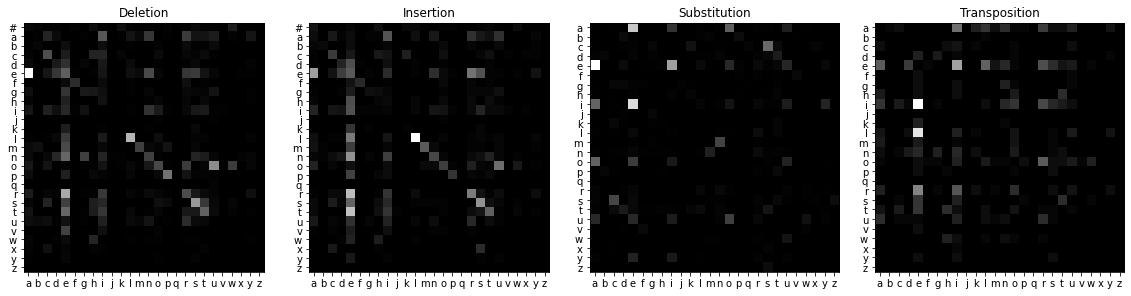

In [27]:
# TODO: visualize confusion matrices
fs = 4
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(4*fs,fs))

axs[0].imshow(del_matrix, cmap='gray')
axs[0].set_title('Deletion')
axs[0].set_yticks(ticks=np.arange(0,len(string.ascii_lowercase)+1,1))
axs[0].set_yticklabels(labels=['#']+list(string.ascii_lowercase))
axs[0].set_xticks(ticks=np.arange(0,len(string.ascii_lowercase),1))
axs[0].set_xticklabels(labels=list(string.ascii_lowercase))

axs[1].imshow(ins_matrix, cmap='gray')
axs[1].set_title('Insertion')
axs[1].set_yticks(ticks=np.arange(0,len(string.ascii_lowercase)+1,1))
axs[1].set_yticklabels(labels=['#']+list(string.ascii_lowercase))
axs[1].set_xticks(ticks=np.arange(0,len(string.ascii_lowercase),1))
axs[1].set_xticklabels(labels=list(string.ascii_lowercase))

axs[2].imshow(sub_matrix, cmap='gray')
axs[2].set_title('Substitution')
axs[2].set_xticks(ticks=np.arange(0,len(string.ascii_lowercase),1))
axs[2].set_xticklabels(labels=list(string.ascii_lowercase))
axs[2].set_yticks(ticks=np.arange(0,len(string.ascii_lowercase),1))
axs[2].set_yticklabels(labels=list(string.ascii_lowercase))

axs[3].imshow(trans_matrix, cmap='gray')
axs[3].set_title('Transposition')
axs[3].set_xticks(ticks=np.arange(0,len(string.ascii_lowercase),1))
axs[3].set_xticklabels(labels=list(string.ascii_lowercase))
axs[3].set_yticks(ticks=np.arange(0,len(string.ascii_lowercase),1))
axs[3].set_yticklabels(labels=list(string.ascii_lowercase))

plt.tight_layout()

### Task 10 (7 Points)
Now that we have the confusion matrices, we can use them to alter the calculate $p(x|w)$.

However the counts in the matrices first have to be normalized to yield probabilities.

We interpret $p(x|w)$ as the probability, that we observe a certain error given we already have observed a certain pattern. In other words, if $\pi_{t}$ is the correct pattern in the correct word and $\pi_f$ is the false pattern in the typo, then we set

\begin{align}
p(x|w)&=p(\pi_t\rightarrow\pi_f|\pi_t)\\
&=\cfrac{p((\pi_t)\wedge(\pi_t\rightarrow\pi_f))}{p(\pi_t)}\\
&=\cfrac{p(\pi_t\rightarrow\pi_f)}{p(\pi_t)}\\
\end{align}

This expression can be approximated by counts over our trainset. 
The nominator $p(\pi_t\rightarrow\pi_f)$ counts, how many times a specific error occured on average, thus corresponding to our confusion matrices.
The denominator $p(\pi_t)$ counts, how many times the correct pattern occured on average. 

Below examples for each operation:

- $w=\text{from},x=\text{frod}\rightarrow\pi_t=\text{m},\pi_f=\text{d}\rightarrow p(x|w)\approx\cfrac{\frac{1}{N}sub[\text{m},\text{d}]}{\frac{1}{N}\#\text{d in dataset}}=\cfrac{sub[\text{m},\text{d}]}{\#\text{d in dataset}}$
- $w=\text{from},x=\text{fromm}\rightarrow\pi_t=\text{m},\pi_f=\text{mm}\rightarrow p(x|w)\approx\cfrac{\frac{1}{N}ins[\text{m},\text{m}]}{\frac{1}{N}\#\text{m in dataset}}=\cfrac{ins[\text{m},\text{m}]}{\#\text{m in dataset}}$
- $w=\text{from},x=\text{frm}\rightarrow\pi_t=\text{ro},\pi_f=\text{r}\rightarrow p(x|w)\approx\cfrac{\frac{1}{N}del[\text{r},\text{o}]}{\frac{1}{N}\#\text{ro in dataset}}=\cfrac{del[\text{r},\text{o}]}{\#\text{ro in dataset}}$
- $w=\text{from},x=\text{frmo}\rightarrow\pi_t=\text{om},\pi_f=\text{mo}\rightarrow p(x|w)\approx\cfrac{\frac{1}{N}trans[\text{o},\text{m}]}{\frac{1}{N}\#\text{om in dataset}}=\cfrac{trans[\text{o},\text{m}]}{\#\text{om in dataset}}$

Implement the noisy channel `error_model` function, that calculates $p(x|w)$ by norming the counts in the confusion matrices as described above.

Based on this error model implement the `correction_noisy_channel` function that outputs the best correction candidate.

Similar to task 5, calculate the sucess rate of the new correction function.

In [37]:
# TODO: Calculate counts
from tqdm.notebook import tqdm
alphabet = string.ascii_lowercase
double_count = np.zeros((len(alphabet)+1, len(alphabet)))
single_count = np.zeros(len(alphabet))
for j in tqdm(range(len(alphabet))):
    y = alphabet[j]
    single_count[j] = sum([right.count(y) for _, right in trainset])
    for i,x in enumerate('#'+alphabet):
        if x == '#':
            double_count[i,j] = sum([right.startswith(y) for _, right in trainset])
        else:
            double_count[i,j] = sum([right.count(x+y) for _, right in trainset])
        
double_count[double_count==0] = 1e-3

def error_model(x,candidate):
    # TODO: Calculate p(x|candidate)
    ident, x, y = get_transformation(x, candidate)
    idx_x = string.ascii_lowercase.find(x)
    idx_y = string.ascii_lowercase.find(y)
    
    if ident == 'del':
        norm = double_count[idx_x+1, idx_y]
        return del_matrix[idx_x+1, idx_y]/norm
    elif ident == 'ins':
        norm = single_count[idx_y]
        return ins_matrix[idx_x+1, idx_y]/norm
    elif ident == 'sub':
        norm = single_count[idx_y]
        return sub_matrix[idx_x, idx_y]/norm
    elif ident == 'trans':
        norm = double_count[idx_x+1, idx_y]
        return trans_matrix[idx_x, idx_y]/norm
    else:
        return None

def correction_noisy_channel(x): 
    # TODO: return best correction candidate based on noisy channel model 
    if x in words:
        return x
    else:
        can = candidates(x)
        if len(can)>0:
            p_w = np.array([language_model(c) for c in can])
            p_x_w = np.array([error_model(x,c) for c in can])
            return can[np.argmax(p_w*p_x_w)]
        else:
            return x

# TODO: calculate success rate
failed1, sr1 = validate(correction_noisy_channel)
print(sr1)

0.7823232323232323
